# Gesture Recognition - Sumit and Deepa
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [3]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [5]:
project_folder='Project_data'

##### Plotting

In [6]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [8]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

##### Sample Cropping

In [10]:
#test_generator=ModelConv3D1()
#test_generator.initialize_path(project_folder)
#test_generator.initialize_image_properties(image_height=160,image_width=160)
#test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

#g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
#batch_data, batch_labels=next(g)
#fig, axes = plt.subplots(nrows=1, ncols=2)
#axes[0].imshow(batch_data[0,15,:,:,:])   
#axes[1].imshow(batch_data[3,15,:,:,:])   

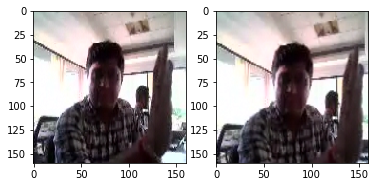

## Experimenting with Image resolution, number of frames to use and batch_size

In [11]:
#conv_3d1.train_model(conv_3d1_model)

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [12]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [13]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - 140s 6s/step - loss: 1.4471 - categorical_accuracy: 0.4750 - val_loss: 2.5027 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-10-2110_11_24.229871/model-00001-1.45520-0.46757-2.50273-0.36000.h5
Epoch 2/3
23/23 [==============================] - 53s 2s/step - loss: 1.0209 - categorical_accuracy: 0.6013 - val_loss: 2.0515 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_init_2020-10-2110_11_24.229871/model-00002-1.01351-0.59879-2.05146-0.30000.h5
Epoch 3/3
23/23 [==============================] - 54s 2s/step - loss: 0.8551 - categorical_accuracy: 0.6632 - val_loss: 1.4491 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-10-2110_11_24.229871/model-00003-0.87404-0.65008-1.44912-0.50000.h5


In [14]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - 169s 7s/step - loss: 1.6233 - categorical_accuracy: 0.4141 - val_loss: 1.4512 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2020-10-2110_15_37.193034/model-00001-1.60020-0.40422-1.45121-0.53000.h5
Epoch 2/2
23/23 [==============================] - 74s 3s/step - loss: 1.0383 - categorical_accuracy: 0.5897 - val_loss: 0.9413 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2020-10-2110_15_37.193034/model-00002-1.02637-0.58673-0.94132-0.61000.h5


In [15]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 92s 8s/step - loss: 1.8108 - categorical_accuracy: 0.3473 - val_loss: 1.9532 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2020-10-2110_19_49.057082/model-00001-1.79038-0.34842-1.95318-0.45000.h5
Epoch 2/2
12/12 [==============================] - 73s 6s/step - loss: 1.0836 - categorical_accuracy: 0.5862 - val_loss: 1.7547 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2020-10-2110_19_49.057082/model-00002-1.14331-0.55354-1.75473-0.53000.h5


In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 50s 4s/step - loss: 1.7065 - categorical_accuracy: 0.3711 - val_loss: 2.2196 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2020-10-2110_22_46.637934/model-00001-1.72491-0.37406-2.21962-0.37000.h5
Epoch 2/2
12/12 [==============================] - 36s 3s/step - loss: 1.0686 - categorical_accuracy: 0.5646 - val_loss: 1.6704 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_2020-10-2110_22_46.637934/model-00002-1.08861-0.55656-1.67043-0.43000.h5


In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - 50s 6s/step - loss: 1.7388 - categorical_accuracy: 0.3577 - val_loss: 1.4650 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_2020-10-2110_24_23.379978/model-00001-1.74620-0.34842-1.46498-0.49000.h5
Epoch 2/2
9/9 [==============================] - 36s 4s/step - loss: 1.1470 - categorical_accuracy: 0.5345 - val_loss: 1.3389 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-10-2110_24_23.379978/model-00002-1.14137-0.53544-1.33893-0.50000.h5


In [18]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 99s 2s/step - loss: 1.5511 - categorical_accuracy: 0.4251 - val_loss: 1.5187 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2020-10-2110_26_02.707909/model-00001-1.55811-0.42081-1.51869-0.47000.h5
Epoch 2/2
45/45 [==============================] - 85s 2s/step - loss: 1.0676 - categorical_accuracy: 0.5808 - val_loss: 1.3963 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2020-10-2110_26_02.707909/model-00002-1.05005-0.58522-1.39632-0.47000.h5


In [19]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 54s 1s/step - loss: 1.4895 - categorical_accuracy: 0.4281 - val_loss: 1.3624 - val_categorical_accuracy: 0.5700

Epoch 00001: saving model to model_init_2020-10-2110_29_17.254375/model-00001-1.50743-0.42383-1.36238-0.57000.h5
Epoch 2/2
45/45 [==============================] - 45s 1s/step - loss: 1.0606 - categorical_accuracy: 0.5822 - val_loss: 1.3501 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-10-2110_29_17.254375/model-00002-1.06249-0.58069-1.35005-0.55000.h5


In [20]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - 44s 984ms/step - loss: 1.4803 - categorical_accuracy: 0.4223 - val_loss: 1.3062 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2020-10-2110_31_04.903771/model-00001-1.48491-0.42383-1.30615-0.53000.h5
Epoch 2/2
45/45 [==============================] - 36s 793ms/step - loss: 1.0440 - categorical_accuracy: 0.5779 - val_loss: 0.9615 - val_categorical_accuracy: 0.6800

Epoch 00002: saving model to model_init_2020-10-2110_31_04.903771/model-00002-1.04269-0.58220-0.96150-0.68000.h5


In [21]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - 44s 655ms/step - loss: 1.6651 - categorical_accuracy: 0.3935 - val_loss: 1.4820 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2020-10-2110_32_35.450213/model-00001-1.67523-0.39065-1.48202-0.50000.h5
Epoch 2/2
67/67 [==============================] - 36s 532ms/step - loss: 1.2475 - categorical_accuracy: 0.5150 - val_loss: 1.2350 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2020-10-2110_32_35.450213/model-00002-1.23551-0.52036-1.23497-0.54000.h5


In [22]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - 80s 1s/step - loss: 1.6004 - categorical_accuracy: 0.3875 - val_loss: 1.6150 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-10-2110_34_04.687265/model-00001-1.59892-0.38462-1.61498-0.44000.h5
Epoch 2/2
67/67 [==============================] - 71s 1s/step - loss: 1.2906 - categorical_accuracy: 0.4925 - val_loss: 0.9150 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2020-10-2110_34_04.687265/model-00002-1.29885-0.48718-0.91504-0.65000.h5


In [23]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - 96s 1s/step - loss: 1.5482 - categorical_accuracy: 0.4323 - val_loss: 1.0144 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_init_2020-10-2110_36_46.637325/model-00001-1.55320-0.42986-1.01441-0.60000.h5
Epoch 2/2
67/67 [==============================] - 85s 1s/step - loss: 1.1817 - categorical_accuracy: 0.5483 - val_loss: 0.8849 - val_categorical_accuracy: 0.6900

Epoch 00002: saving model to model_init_2020-10-2110_36_46.637325/model-00002-1.18525-0.55053-0.88492-0.69000.h5


In [24]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - 51s 766ms/step - loss: 1.6074 - categorical_accuracy: 0.3965 - val_loss: 1.0428 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2020-10-2110_40_01.176014/model-00001-1.61249-0.39367-1.04279-0.58000.h5
Epoch 2/2
67/67 [==============================] - 43s 639ms/step - loss: 1.2292 - categorical_accuracy: 0.5114 - val_loss: 1.0223 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-10-2110_40_01.176014/model-00002-1.23012-0.50980-1.02230-0.60000.h5


In [25]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - 60s 4s/step - loss: 1.5430 - categorical_accuracy: 0.4001 - val_loss: 2.5449 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_2020-10-2110_41_46.069973/model-00001-1.55217-0.39819-2.54492-0.35000.h5
Epoch 2/2
17/17 [==============================] - 37s 2s/step - loss: 0.9690 - categorical_accuracy: 0.6245 - val_loss: 1.2704 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2020-10-2110_41_46.069973/model-00002-0.96586-0.62594-1.27036-0.54000.h5


##### As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size

##### So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints . Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes

# Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [26]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_57 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_85 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_57 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_58 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_86 (Batc (None, 10, 80, 80, 32)    128       
__________

In [28]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 74s 4s/step - loss: 1.6685 - categorical_accuracy: 0.3795 - val_loss: 2.5705 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2020-10-2110_43_37.408280/model-00001-1.66593-0.37707-2.57052-0.43000.h5
Epoch 2/15
17/17 [==============================] - 46s 3s/step - loss: 1.0802 - categorical_accuracy: 0.5921 - val_loss: 1.1345 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-10-2110_43_37.408280/model-00002-1.07951-0.59276-1.13446-0.57000.h5
Epoch 3/15
17/17 [==============================] - 59s 3s/step - loss: 0.7791 - categorical_accuracy: 0.6912 - val_loss: 1.1285 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2020-10-2110_43_37.408280/model-00003-0.77390-0.69532-1.12853-0.66000.h5
Epoch 4/15
17/17 [==============================] - 60s 4s/step - loss: 0.6754 - categorical_accuracy: 0.7355 - val_loss: 2.0788 - val_categoric

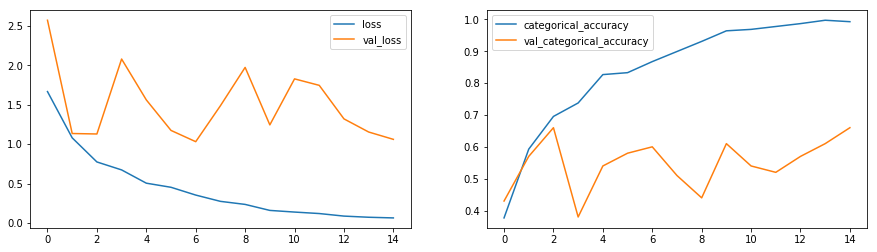

In [29]:
plot(history_model1)

##### Model is clearly overfitting. So we need to do data augmentation

# Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [30]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_61 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_61 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_91 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_61 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_62 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_92 (Batc (None, 10, 80, 80, 32)    128       
__________

In [31]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 147s 4s/step - loss: 1.9097 - categorical_accuracy: 0.3826 - val_loss: 8.0119 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2020-10-2110_58_56.648219/model-00001-1.86338-0.39216-8.01190-0.24000.h5
Epoch 2/25
34/34 [==============================] - 128s 4s/step - loss: 1.4585 - categorical_accuracy: 0.4993 - val_loss: 4.2065 - val_categorical_accuracy: 0.3300

Epoch 00002: saving model to model_init_2020-10-2110_58_56.648219/model-00002-1.41444-0.50754-4.20647-0.33000.h5
Epoch 3/25
34/34 [==============================] - 136s 4s/step - loss: 1.3453 - categorical_accuracy: 0.5563 - val_loss: 5.0967 - val_categorical_accuracy: 0.3200

Epoch 00003: saving model to model_init_2020-10-2110_58_56.648219/model-00003-1.33207-0.55354-5.09675-0.32000.h5
Epoch 4/25
34/34 [==============================] - 137s 4s/step - loss: 1.1017 - categorical_accuracy: 0.5898 - val_loss: 1.7059 - val_categ

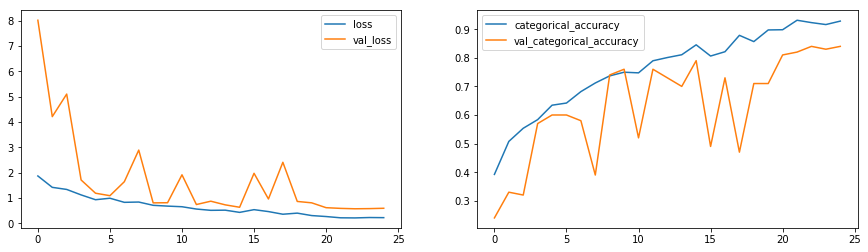

In [32]:
plot(history_model2)

##### Model is not overfitting and we get a best validation accuracy of 85% and training accuracy of 91%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

# Model 3 - Reduce filter size to (2,2,2) and image res to 120 x  120

In [33]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [34]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_65 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_65 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_65 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_66 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_98 (Batc (None, 8, 60, 60, 32)     128       
__________

In [35]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 99s 4s/step - loss: 2.3367 - categorical_accuracy: 0.2954 - val_loss: 1.4485 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-10-2111_55_57.756975/model-00001-2.28465-0.30694-1.44847-0.44000.h5
Epoch 2/30
23/23 [==============================] - 80s 3s/step - loss: 1.6368 - categorical_accuracy: 0.4447 - val_loss: 1.1654 - val_categorical_accuracy: 0.5900

Epoch 00002: saving model to model_init_2020-10-2111_55_57.756975/model-00002-1.58505-0.45551-1.16535-0.59000.h5
Epoch 3/30
23/23 [==============================] - 89s 4s/step - loss: 1.2926 - categorical_accuracy: 0.5398 - val_loss: 1.2417 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-10-2111_55_57.756975/model-00003-1.26811-0.55430-1.24173-0.61000.h5
Epoch 4/30
23/23 [==============================] - 89s 4s/step - loss: 1.2014 - categorical_accuracy: 0.5678 - val_loss: 0.9230 - val_categoric


Epoch 00029: saving model to model_init_2020-10-2111_55_57.756975/model-00029-0.51020-0.81900-0.67423-0.83000.h5
Epoch 30/30
23/23 [==============================] - 90s 4s/step - loss: 0.4969 - categorical_accuracy: 0.8140 - val_loss: 0.6730 - val_categorical_accuracy: 0.8300

Epoch 00030: saving model to model_init_2020-10-2111_55_57.756975/model-00030-0.47493-0.81976-0.67304-0.83000.h5


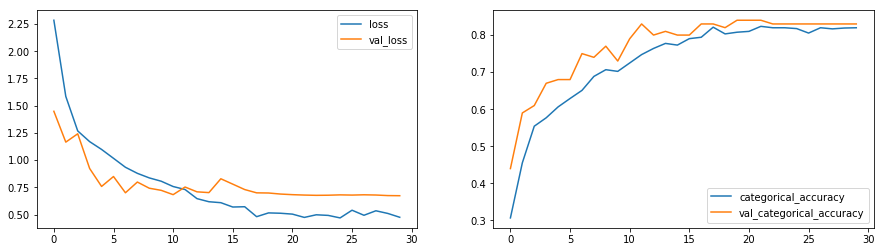

In [36]:
plot(history_model3)

##### Model has a  best validation accuracy of 84% and training accuracy of 84% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

# Model 4 - Adding more layers

In [37]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [38]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_69 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_69 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_103 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_70 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_104 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_69 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [39]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 123s 4s/step - loss: 1.9909 - categorical_accuracy: 0.3506 - val_loss: 10.7550 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-10-2112_41_14.203731/model-00001-2.01643-0.34691-10.75503-0.23000.h5
Epoch 2/30
34/34 [==============================] - 96s 3s/step - loss: 1.5330 - categorical_accuracy: 0.4845 - val_loss: 4.6577 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2020-10-2112_41_14.203731/model-00002-1.49505-0.49246-4.65769-0.44000.h5
Epoch 3/30
34/34 [==============================] - 96s 3s/step - loss: 1.4779 - categorical_accuracy: 0.4971 - val_loss: 3.5570 - val_categorical_accuracy: 0.4000

Epoch 00003: saving model to model_init_2020-10-2112_41_14.203731/model-00003-1.47920-0.49698-3.55700-0.40000.h5
Epoch 4/30
34/34 [==============================] - 96s 3s/step - loss: 1.3631 - categorical_accuracy: 0.5180 - val_loss: 3.1710 - val_catego

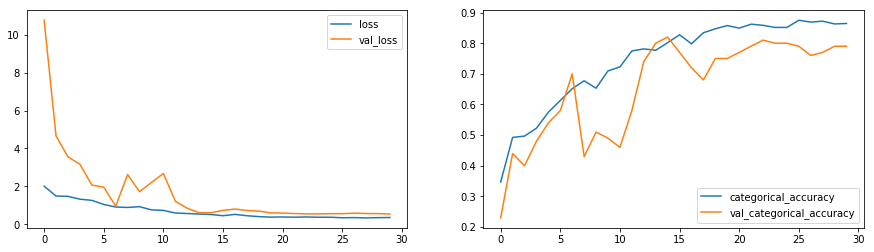

In [40]:
plot(history_model4)

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

# Model 5 Adding dropout at convolution layers

In [8]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [10]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - 215s 6s/step - loss: 1.8077 - categorical_accuracy: 0.3904 - val_loss: 1.8598 - val_categorical_accuracy: 0.4800

Epoch 00001: saving model to model_init_2020-10-2114_25_35.032053/model-00001-1.78725-0.39593-1.85977-0.48000.h5
Epoch 2/22
34/34 [==============================] - 116s 3s/step - loss: 1.4469 - categorical_accuracy: 0.4636 - val_loss: 1.9664 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model_init_2020-10-2114_25_35.032053/model-00002-1.44476-0.45852-1.96644-0.46000.h5
Epoch 3/22
34/34 [==============================] - 136s 4s/step - loss: 1.2006 - categorical_accuracy: 0.5636 - val_loss: 1.1995 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model_init_2020-10-2114_25_35.032053/model-00003-1.12576-0.57768-1.19947-0.45000.h5
Epoch 4/22
34/34 [==============================] - 101s 3s/step - loss: 1.1338 - categorical_accuracy: 0.5625 - val_loss: 1.3153 - val_categ

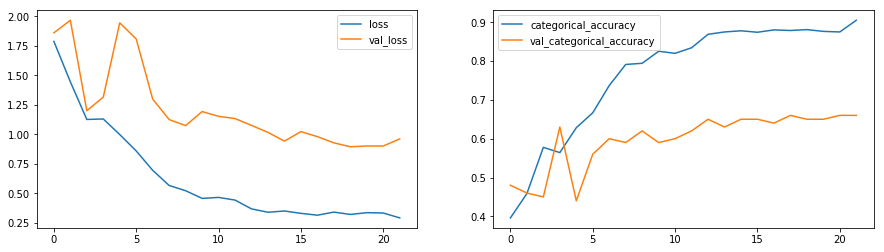

In [11]:
plot(history_model5)

##### Adding dropouts has further reduced validation accuracy as its not to learn  generalizable features

##### All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

# Model 6 - reducing the number of parameters

In [16]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_14 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 50, 50, 32)     128       
__________

In [18]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - 87s 3s/step - loss: 1.8121 - categorical_accuracy: 0.3690 - val_loss: 1.2529 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2020-10-2115_48_18.600018/model-00001-1.82281-0.35747-1.25286-0.53000.h5
Epoch 2/30
34/34 [==============================] - 81s 2s/step - loss: 1.2511 - categorical_accuracy: 0.5239 - val_loss: 1.0526 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-10-2115_48_18.600018/model-00002-1.23581-0.52866-1.05258-0.60000.h5
Epoch 3/30
34/34 [==============================] - 83s 2s/step - loss: 1.0380 - categorical_accuracy: 0.5861 - val_loss: 0.9325 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2020-10-2115_48_18.600018/model-00003-1.03122-0.58824-0.93254-0.66000.h5
Epoch 4/30
34/34 [==============================] - 83s 2s/step - loss: 0.9003 - categorical_accuracy: 0.6556 - val_loss: 0.9090 - val_categorica

34/34 [==============================] - 82s 2s/step - loss: 0.4299 - categorical_accuracy: 0.8561 - val_loss: 0.7631 - val_categorical_accuracy: 0.7000

Epoch 00029: saving model to model_init_2020-10-2115_48_18.600018/model-00029-0.39720-0.86501-0.76308-0.70000.h5
Epoch 30/30
34/34 [==============================] - 82s 2s/step - loss: 0.4195 - categorical_accuracy: 0.8609 - val_loss: 0.7623 - val_categorical_accuracy: 0.6900

Epoch 00030: saving model to model_init_2020-10-2115_48_18.600018/model-00030-0.40909-0.86576-0.76228-0.69000.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.2799999637991278e-08.


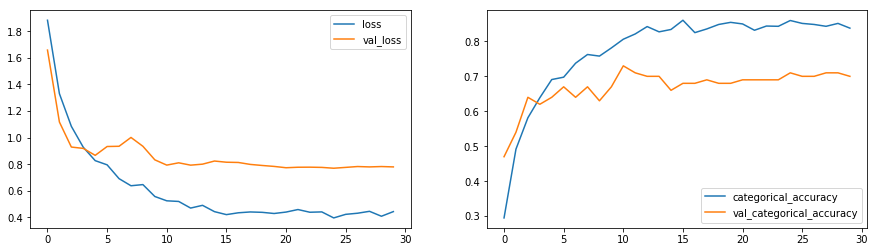

In [15]:
plot(history_model6)

###### For the above low memory foot print model the best validation accuracy of 77%

# Model 7 - reducing the number of parameters

In [8]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 32)     128       
__________

In [10]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 203s 6s/step - loss: 1.7718 - categorical_accuracy: 0.3786 - val_loss: 1.6216 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to model_init_2020-10-2202_15_37.282707/model-00001-1.78703-0.37557-1.62160-0.41000.h5
Epoch 2/25
34/34 [==============================] - 106s 3s/step - loss: 1.1890 - categorical_accuracy: 0.5361 - val_loss: 1.2348 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model_init_2020-10-2202_15_37.282707/model-00002-1.17795-0.54525-1.23483-0.58000.h5
Epoch 3/25
34/34 [==============================] - 116s 3s/step - loss: 0.9972 - categorical_accuracy: 0.6107 - val_loss: 0.9653 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-10-2202_15_37.282707/model-00003-0.96999-0.61765-0.96533-0.64000.h5
Epoch 4/25
34/34 [==============================] - 88s 3s/step - loss: 0.8905 - categorical_accuracy: 0.6350 - val_loss: 0.9730 - val_categor

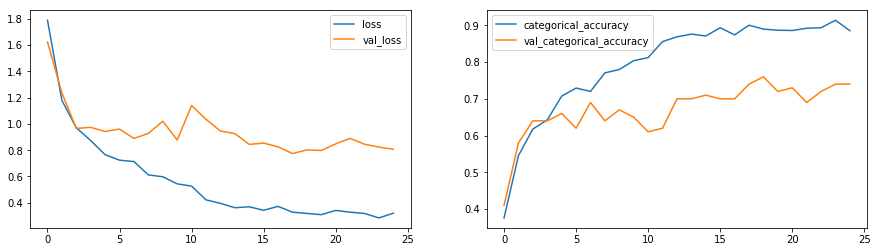

In [11]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 76%

# Model 8 - reducing the number of parameters

In [12]:
class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_6 (Activation)    (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 60, 60, 16)     64        
__________

In [14]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 94s 3s/step - loss: 2.0205 - categorical_accuracy: 0.2833 - val_loss: 1.5066 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to model_init_2020-10-2202_57_54.498603/model-00001-2.01071-0.28205-1.50656-0.41000.h5
Epoch 2/30
34/34 [==============================] - 87s 3s/step - loss: 1.4461 - categorical_accuracy: 0.4286 - val_loss: 1.3614 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2020-10-2202_57_54.498603/model-00002-1.44966-0.42685-1.36144-0.47000.h5
Epoch 3/30
34/34 [==============================] - 88s 3s/step - loss: 1.3267 - categorical_accuracy: 0.4875 - val_loss: 1.3749 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_2020-10-2202_57_54.498603/model-00003-1.30558-0.48718-1.37488-0.49000.h5
Epoch 4/30
34/34 [==============================] - 89s 3s/step - loss: 1.1637 - categorical_accuracy: 0.5511 - val_loss: 1.1455 - val_categorica

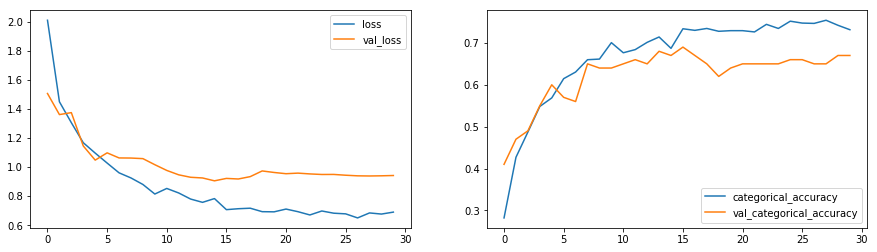

In [15]:
plot(history_model8)

###### For the above low memory foot print model the best validation accuracy of 78%

# Model 9 - CNN- LSTM Model

In [16]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [18]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 169s 5s/step - loss: 1.4357 - categorical_accuracy: 0.3815 - val_loss: 1.3456 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-10-2203_43_24.800034/model-00001-1.43927-0.37858-1.34556-0.44000.h5
Epoch 2/20
34/34 [==============================] - 98s 3s/step - loss: 1.1118 - categorical_accuracy: 0.5603 - val_loss: 0.9858 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2020-10-2203_43_24.800034/model-00002-1.09231-0.56184-0.98578-0.61000.h5
Epoch 3/20
34/34 [==============================] - 100s 3s/step - loss: 1.0005 - categorical_accuracy: 0.5927 - val_loss: 1.9703 - val_categorical_accuracy: 0.2900

Epoch 00003: saving model to model_init_2020-10-2203_43_24.800034/model-00003-1.01028-0.58673-1.97027-0.29000.h5
Epoch 4/20
34/34 [==============================] - 100s 3s/step - loss: 0.8180 - categorical_accuracy: 0.6851 - val_loss: 1.2086 - val_catego

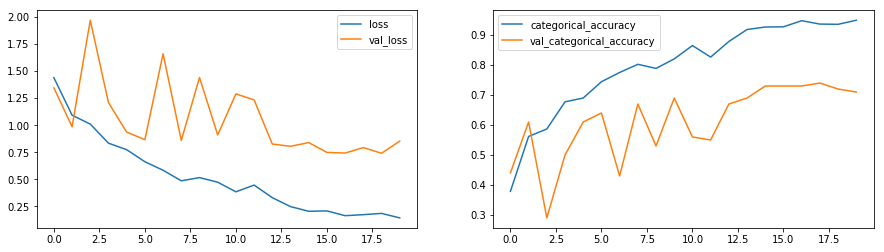

In [19]:
plot(history_model9)

##### For CNN - LSTM model we get a best validation accuracy of 74%

### As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again

# More Augmentation

In [8]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [4]:
#class Test(ModelBuilderMoreAugmentation):
#    def define_model(self):
#        pass

#test_generator=Test()
#test_generator.initialize_path(project_folder)
#test_generator.initialize_image_properties(image_height=160,image_width=160)
#test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

#g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
#batch_data, batch_labels=next(g)
#fig, axes = plt.subplots(nrows=1, ncols=2)
#axes[0].imshow(batch_data[0,29,:,:,:])   
#axes[1].imshow(batch_data[3,29,:,:,:])   

# Model 10 - (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [22]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_10 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 10, 80, 80, 32)    128       
__________

In [24]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - 177s 5s/step - loss: 1.9890 - categorical_accuracy: 0.3550 - val_loss: 1.3663 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2020-10-2204_18_53.769278/model-00001-2.00360-0.35143-1.36634-0.53000.h5
Epoch 2/30
34/34 [==============================] - 135s 4s/step - loss: 1.3932 - categorical_accuracy: 0.5151 - val_loss: 1.0429 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2020-10-2204_18_53.769278/model-00002-1.39621-0.51131-1.04286-0.65000.h5
Epoch 3/30
34/34 [==============================] - 138s 4s/step - loss: 1.1651 - categorical_accuracy: 0.5887 - val_loss: 1.1466 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-10-2204_18_53.769278/model-00003-1.18277-0.58673-1.14660-0.64000.h5
Epoch 4/30
34/34 [==============================] - 137s 4s/step - loss: 1.0464 - categorical_accuracy: 0.6306 - val_loss: 0.8672 - val_categ

34/34 [==============================] - 137s 4s/step - loss: 0.4167 - categorical_accuracy: 0.8558 - val_loss: 0.5921 - val_categorical_accuracy: 0.8500

Epoch 00030: saving model to model_init_2020-10-2204_18_53.769278/model-00030-0.34721-0.86878-0.59213-0.85000.h5


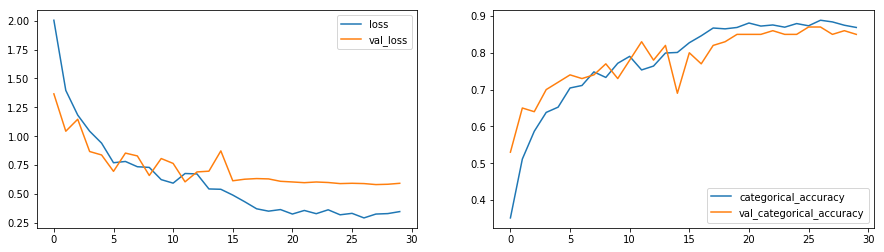

In [25]:
plot(history_model10)

# Model 11 - (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [13]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 32)     128       
__________

In [15]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 99s 4s/step - loss: 2.1575 - categorical_accuracy: 0.3283 - val_loss: 1.2097 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2020-10-2209_02_53.745426/model-00001-2.18588-0.32805-1.20967-0.47000.h5
Epoch 2/30
23/23 [==============================] - 89s 4s/step - loss: 1.5388 - categorical_accuracy: 0.4839 - val_loss: 0.9622 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2020-10-2209_02_53.745426/model-00002-1.50982-0.49623-0.96217-0.61000.h5
Epoch 3/30
23/23 [==============================] - 90s 4s/step - loss: 1.3274 - categorical_accuracy: 0.5366 - val_loss: 0.8791 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-10-2209_02_53.745426/model-00003-1.26969-0.54449-0.87908-0.64000.h5
Epoch 4/30
23/23 [==============================] - 90s 4s/step - loss: 1.1872 - categorical_accuracy: 0.5883 - val_loss: 0.8467 - val_categoric


Epoch 00029: saving model to model_init_2020-10-2209_02_53.745426/model-00029-0.57198-0.78356-0.62327-0.82000.h5
Epoch 30/30
23/23 [==============================] - 90s 4s/step - loss: 0.5500 - categorical_accuracy: 0.7933 - val_loss: 0.6217 - val_categorical_accuracy: 0.8200

Epoch 00030: saving model to model_init_2020-10-2209_02_53.745426/model-00030-0.53877-0.80468-0.62167-0.82000.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 3.200000037395512e-07.


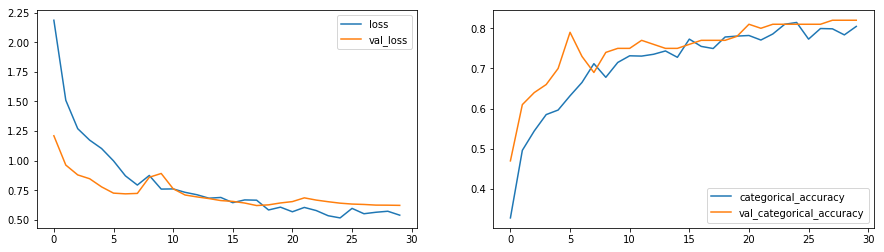

In [16]:
plot(history_model11)

# Model 12 - Adding more layers - Similar to model 4

In [9]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d12_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [11]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 120s 4s/step - loss: 2.1871 - categorical_accuracy: 0.3083 - val_loss: 2.0892 - val_categorical_accuracy: 0.3800

Epoch 00001: saving model to model_init_2020-10-2211_28_49.008031/model-00001-2.16528-0.30769-2.08915-0.38000.h5
Epoch 2/30
34/34 [==============================] - 97s 3s/step - loss: 1.6419 - categorical_accuracy: 0.4441 - val_loss: 2.1727 - val_categorical_accuracy: 0.4200

Epoch 00002: saving model to model_init_2020-10-2211_28_49.008031/model-00002-1.60391-0.45098-2.17269-0.42000.h5
Epoch 3/30
34/34 [==============================] - 98s 3s/step - loss: 1.4086 - categorical_accuracy: 0.5166 - val_loss: 1.6020 - val_categorical_accuracy: 0.5100

Epoch 00003: saving model to model_init_2020-10-2211_28_49.008031/model-00003-1.42108-0.51282-1.60199-0.51000.h5
Epoch 4/30
34/34 [==============================] - 102s 3s/step - loss: 1.2047 - categorical_accuracy: 0.5721 - val_loss: 1.1380 - val_categor

34/34 [==============================] - 102s 3s/step - loss: 0.3715 - categorical_accuracy: 0.8620 - val_loss: 0.6308 - val_categorical_accuracy: 0.8200

Epoch 00030: saving model to model_init_2020-10-2211_28_49.008031/model-00030-0.33564-0.87104-0.63076-0.82000.h5


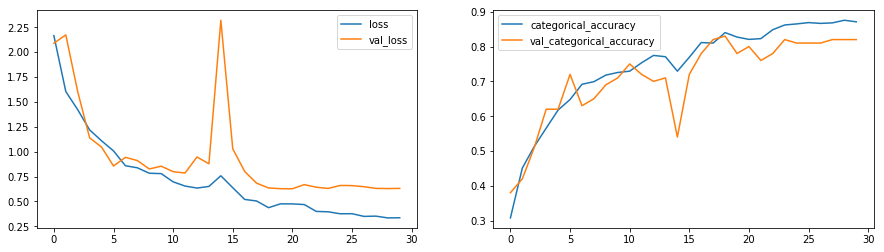

In [12]:
plot(history_model12)

# Model 13 - Adding dropouts - Similar to Model 5

In [9]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=120,image_width=120)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [11]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 233s 7s/step - loss: 2.0671 - categorical_accuracy: 0.3113 - val_loss: 3.0086 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2020-10-2210_37_56.730375/model-00001-2.06454-0.31071-3.00864-0.22000.h5
Epoch 2/25
34/34 [==============================] - 98s 3s/step - loss: 1.6896 - categorical_accuracy: 0.3734 - val_loss: 4.2956 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-10-2210_37_56.730375/model-00002-1.68755-0.37858-4.29560-0.25000.h5
Epoch 3/25
34/34 [==============================] - 102s 3s/step - loss: 1.4234 - categorical_accuracy: 0.4444 - val_loss: 3.9902 - val_categorical_accuracy: 0.2700

Epoch 00003: saving model to model_init_2020-10-2210_37_56.730375/model-00003-1.41691-0.44721-3.99022-0.27000.h5
Epoch 4/25
34/34 [==============================] - 100s 3s/step - loss: 1.2895 - categorical_accuracy: 0.5232 - val_loss: 3.6123 - val_catego

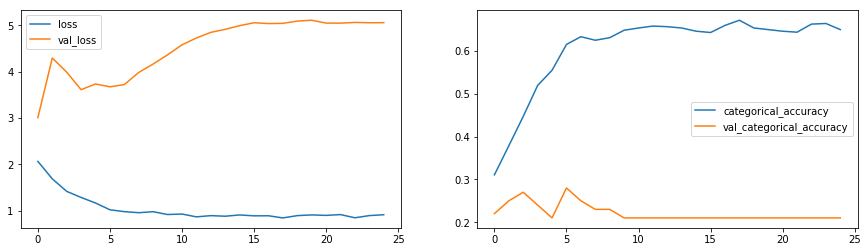

In [12]:
plot(history_model13)

# Model 14 - CNN LSTM with GRU - Similar to Model 9

In [10]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

In [12]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573541
Epoch 1/20
34/34 [==============================] - 177s 5s/step - loss: 1.5089 - categorical_accuracy: 0.3300 - val_loss: 1.1463 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2020-10-2207_15_36.312418/model-00001-1.50610-0.33409-1.14629-0.58000.h5
Epoch 2/20
34/34 [==============================] - 101s 3s/step - loss: 1.0948 - categorical_accuracy: 0.5666 - val_loss: 1.0033 - val_categorical_accuracy: 0.5900

Epoch 00002: saving model to model_init_2020-10-2207_15_36.312418/model-00002-1.10359-0.56410-1.00331-0.59000.h5
Epoch 3/20
34/34 [==============================] - 102s 3s/step - loss: 0.8931 - categorical_accuracy: 0.6523 - val_loss: 0.9560 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2020-10-2207_15_36.312418/model-00003-0.90178-0.64781-0.95595-0.65000.h5
Epoch 4/20
34/34 [==============================] - 102s 3s/step - loss: 0.7282 - categorical_accuracy: 0.7138 - val_loss: 0.9304 - val_categ

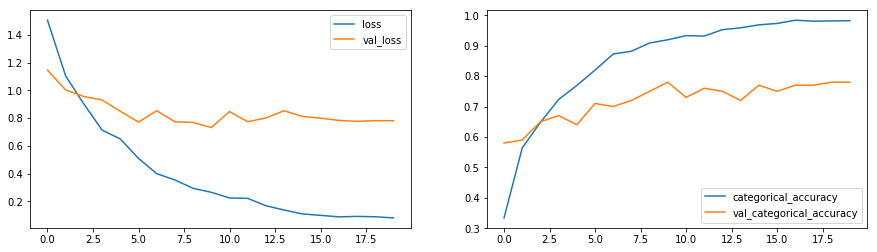

In [14]:
plot(history_model17)

### We see that overfitting is considerably less when we do more augmentation. However there is not much improvement on accuracy

# Model 15 - Transfer Learning

In [15]:
from keras.applications import mobilenet

In [16]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [17]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_28 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_29 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
__________

In [18]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model15=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - 97s 726ms/step - loss: 1.4286 - categorical_accuracy: 0.3712 - val_loss: 1.3605 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to model_init_2020-10-2207_52_06.726120/model-00001-1.42604-0.37179-1.36045-0.41000.h5
Epoch 2/20
133/133 [==============================] - 91s 684ms/step - loss: 1.1734 - categorical_accuracy: 0.5258 - val_loss: 1.2666 - val_categorical_accuracy: 0.5100

Epoch 00002: saving model to model_init_2020-10-2207_52_06.726120/model-00002-1.17128-0.52640-1.26665-0.51000.h5
Epoch 3/20
133/133 [==============================] - 93s 697ms/step - loss: 1.0180 - categorical_accuracy: 0.6063 - val_loss: 1.0783 - val_categorical_accuracy: 0.5400

Epoch 00003: saving model to model_init_2020-10-2207_52_06.726120/model-00003-1.01564-0.60709-1.07832-0.54000.h5
Epoch 4/20
133/133 [==============================] - 92s 695ms/step - loss: 0.8594 - categorical_accuracy: 0.6702 - val_loss: 1.

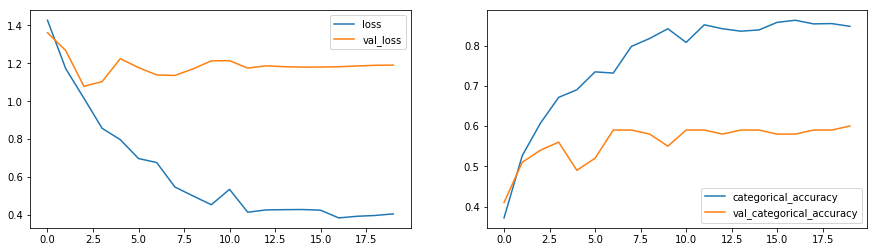

In [19]:
plot(history_model15)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

# Model 16 - Transfer Learning with GRU and training all weights

In [20]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_31 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_32 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_33 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
__________

In [22]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model16=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3692869
Epoch 1/20
133/133 [==============================] - 103s 775ms/step - loss: 1.2828 - categorical_accuracy: 0.4699 - val_loss: 0.7127 - val_categorical_accuracy: 0.6800

Epoch 00001: saving model to model_init_2020-10-2208_24_08.780315/model-00001-1.28383-0.46983-0.71273-0.68000.h5
Epoch 2/20
133/133 [==============================] - 92s 689ms/step - loss: 0.7723 - categorical_accuracy: 0.6962 - val_loss: 1.3111 - val_categorical_accuracy: 0.4500

Epoch 00002: saving model to model_init_2020-10-2208_24_08.780315/model-00002-0.77412-0.69532-1.31113-0.45000.h5
Epoch 3/20
133/133 [==============================] - 99s 741ms/step - loss: 0.6078 - categorical_accuracy: 0.7779 - val_loss: 0.4805 - val_categorical_accuracy: 0.8000

Epoch 00003: saving model to model_init_2020-10-2208_24_08.780315/model-00003-0.60759-0.77828-0.48052-0.80000.h5
Epoch 4/20
133/133 [==============================] - 94s 710ms/step - loss: 0.4615 - categorical_accuracy: 0.8278 - val_loss: 0

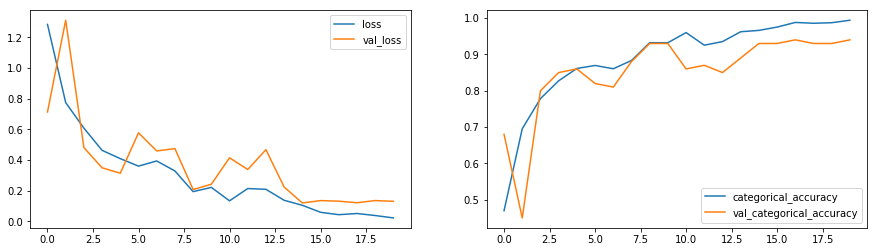

In [23]:
plot(history_model16)

### Consolidated Models

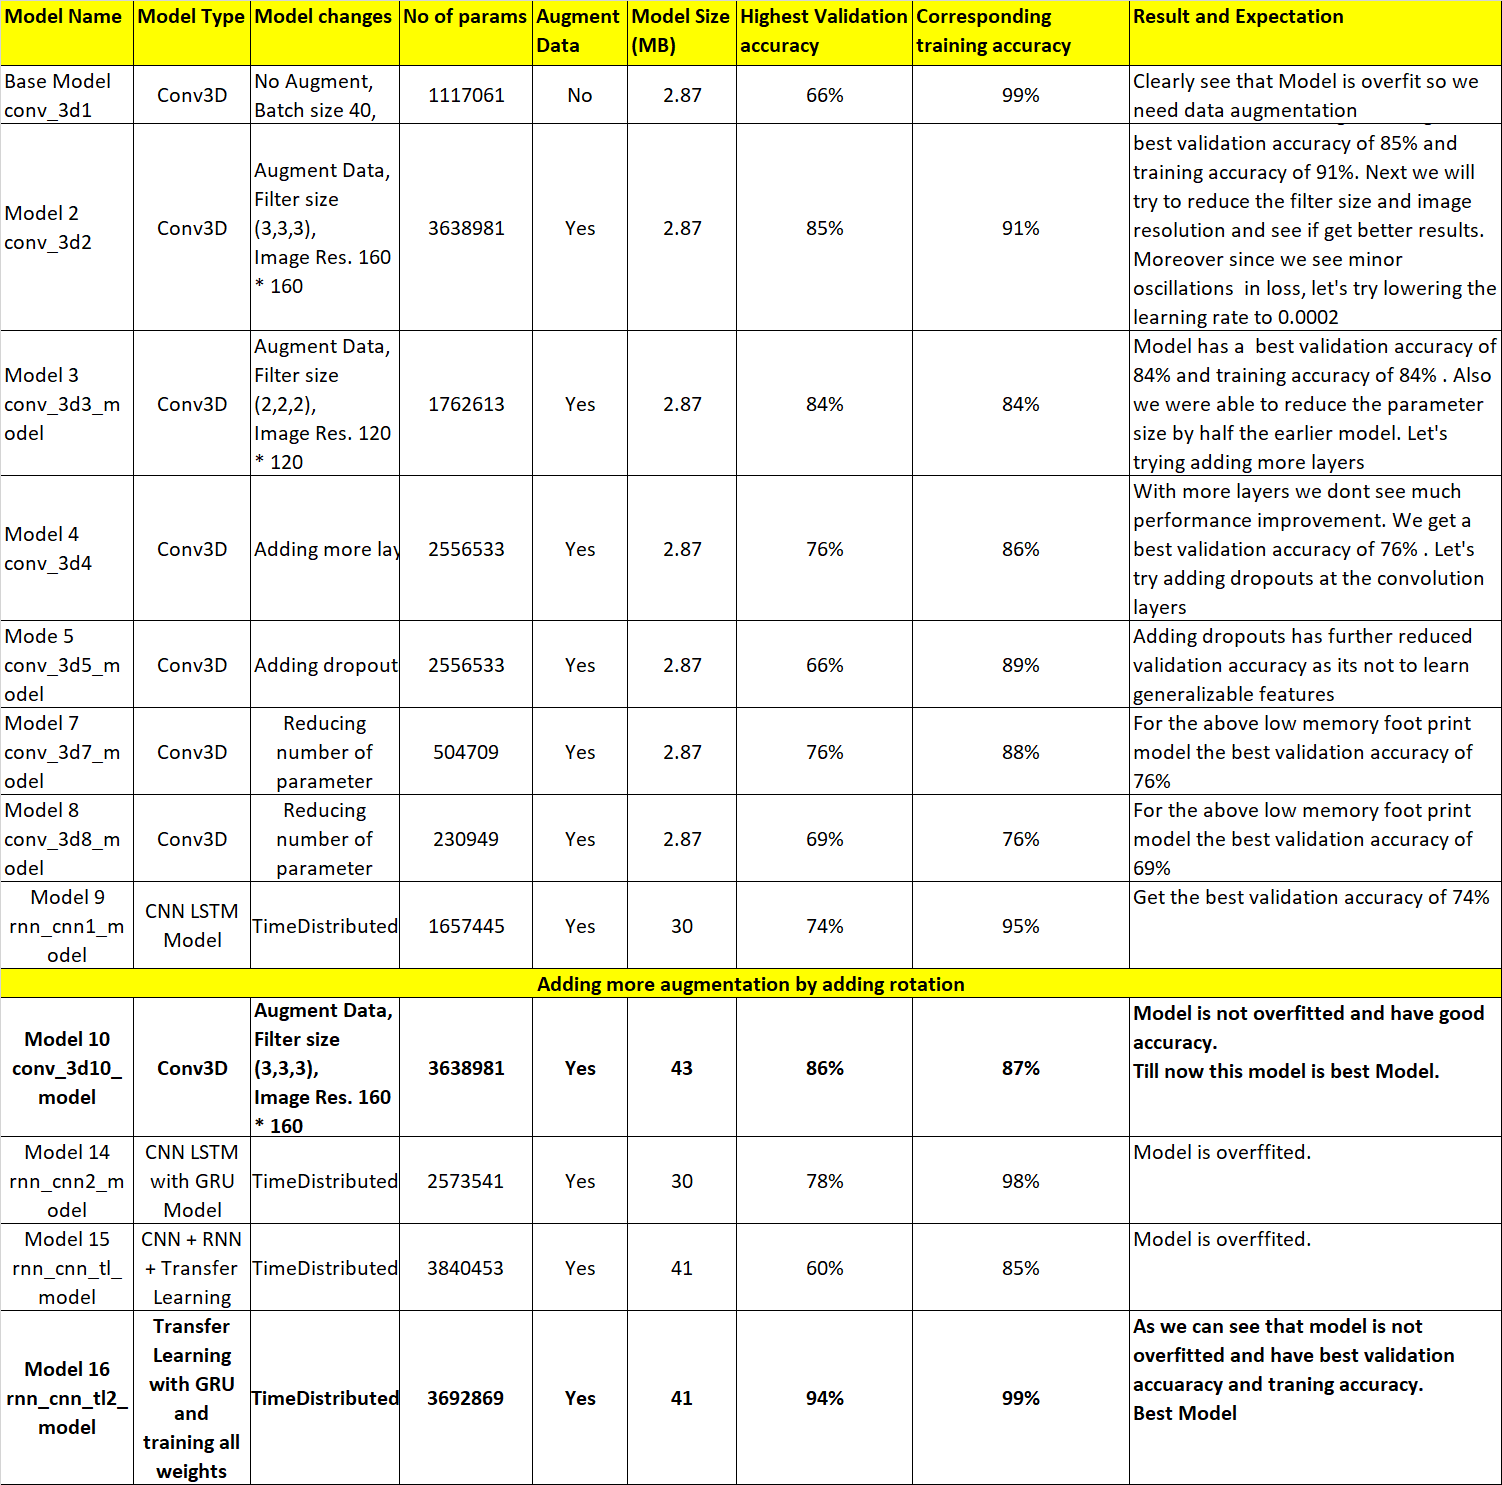

#### Model Links
- Model 10: https://drive.google.com/file/d/162pXjb6s4bJa0ilxTcYd8KKL5Yavah4q/view?usp=sharing
- Model 16: https://drive.google.com/file/d/1zkveVQUvKlsGKVV4k5cgZGFJJ1_JTGSt/view?usp=sharing